In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from lib.loads import parse_loads, convert_offline_to_online_input, select_load_from_last_day
from lib.model import build_model, FACEBOOK_2009_0, FACEBOOK_2009_1, FACEBOOK_2010, LANL_MUSTANG, MICROSOFT_FIDDLE, ALIBABA, ENERGY_MODEL_WIERMAN, ENERGY_MODEL_ALTERNATIVE
from lib.utils import summarize_distribution, plot_cdf, plot

In [3]:
# import logging

# FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
# logging.basicConfig(format=FORMAT)
# logging.getLogger().setLevel(logging.DEBUG)

In [4]:
TIME_SLOT_LENGTH = 60 * 60
NORMALIZED_SWITCHING_COST = 4
REVENUE_LOSS = 0.1

In [5]:
TRACE = FACEBOOK_2009_0

# Model

In [6]:
model = build_model(
  TRACE,
  ENERGY_MODEL_ALTERNATIVE,
  TIME_SLOT_LENGTH,
  NORMALIZED_SWITCHING_COST,
  REVENUE_LOSS,
)

# Inputs

In [7]:
offline_input = select_load_from_last_day(parse_loads(TRACE), TIME_SLOT_LENGTH)
perfect_knowledge_online_input = convert_offline_to_online_input(offline_input)


In [8]:
offline_input

[[84],
 [178],
 [200],
 [208],
 [361],
 [259],
 [462],
 [430],
 [223],
 [221],
 [117],
 [66],
 [149],
 [341],
 [158],
 [154],
 [152],
 [302],
 [431],
 [423],
 [301],
 [132],
 [542]]

# Execute

## Offline

In [9]:
from lib.offline import evaluate_1d

opt, iopt, runtime_opt, runtime_iopt = evaluate_1d(model, offline_input)

In [ ]:
opt, iopt

(2191853.1190362326, 1)

In [11]:
from lib.offline import evaluate_static

opts, iopts, runtime_opts, runtime_iopts = evaluate_static(model, offline_input)

[[1437], [1437], [1437], [1437]]


In [12]:
opts, iopts

(1, 34847329.36597688)

### Fractional vs Integral

In [13]:
opt_vs_iopt = iopt / opt
opts_vs_iopts = iopts / opts
opt_vs_iopt, opts_vs_iopts

(33673383.9573811, 34847329.36597688)

### Opt vs OptS

In [14]:
opt_vs_opts = opts / opt
iopt_vs_iopts = iopts / iopt
opt_vs_opts, iopt_vs_iopts

(1.0, 1.0348627096724698)

### Runtimes

In [15]:
runtime_opt, runtime_iopt, runtime_opts, runtime_iopts

(0, 966, 0, 5957)

### Approximation algorithm

In [16]:
gammas = np.logspace(
  0.2, 3, 8, base=2
)
gammas

array([1.14869835, 1.51571657, 2.        , 2.63901582, 3.48220225,
       4.59479342, 6.06286627, 8.        ])

In [17]:
from lib.offline import evaluate_approx_graph_search

x, y, approx_opt_runtimes = evaluate_approx_graph_search(model, offline_input, gammas)

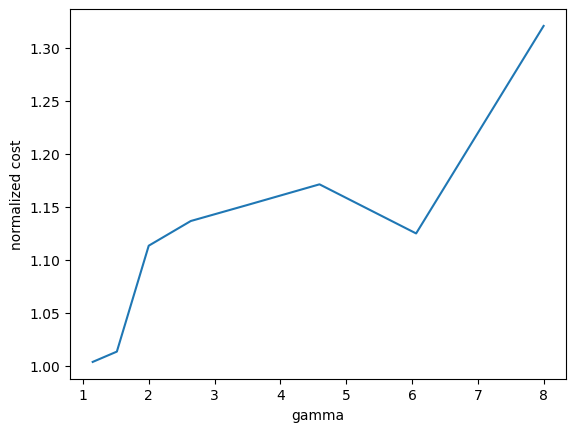

In [18]:
# plt.axhline(y=iopt, color='r', linestyle='-')
plot(x, np.array(y) / iopt, 'gamma', 'normalized cost', 'approx_graph_search')
plt.show()

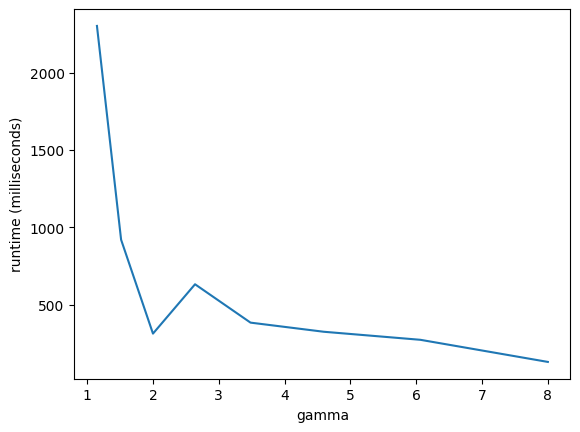

In [19]:
plot(x, approx_opt_runtimes, 'gamma', 'runtime (milliseconds)', 'approx_graph_search_runtime')
plt.show()

## Online

In [62]:
from lib.online import evaluate_fractional_lazy_capacity_provisioning

initial_alg, alg, initial_ialg, ialg, energy_cost, revenue_loss, switching_cost, initial_runtime, runtimes, memory = evaluate_fractional_lazy_capacity_provisioning(model, [], perfect_knowledge_online_input)

100%|██████████| 23/23 [00:06<00:00,  3.70it/s]

Resulting schedule: [[75], [158], [177], [242], [320], [320], [491], [491], [491], [491], [491], [491], [491], [491], [491], [491], [491], [491], [586], [586], [586], [586], [629]]


In [63]:
alg, ialg, energy_cost, revenue_loss, switching_cost, memory[len(memory) - 1]

(2135234.1958627375,
 2134778.226267878,
 1596853.44,
 231325.026267878,
 306599.76,
 [(74.283823, 114.18882099999999),
  (157.410957, 241.971552),
  (176.866245, 271.878149),
  (241.971552, 282.75327799999997),
  (319.243569, 490.740057),
  (282.75327799999997, 352.0822),
  (490.740057, 628.0385259999999),
  (380.262427, 584.538013),
  (303.144135, 628.0385259999999),
  (300.425353, 628.038522),
  (159.04871699999998, 628.0385259999999),
  (89.71978899999999, 628.0385289999999),
  (162.663165, 628.0385299999999),
  (463.55224799999996, 628.038537),
  (214.78373499999998, 628.038537),
  (209.346172, 628.038549),
  (206.627388, 628.0385299999999),
  (410.53599499999996, 628.038548),
  (585.897401, 628.038548),
  (575.022284, 628.038548),
  (409.17661, 628.038567),
  (179.43957699999999, 628.038539),
  (628.038559, 736.789774)])

## Evaluation

### Competitive Ratio

In [24]:
cr = alg / opt
icr = ialg / iopt
cr, icr

(34265089.44664767, 1.0175719045646099)

### Competitive Difference

In [25]:
cd = alg - opt
icd = ialg - iopt
cd, icd

(34265088.44664767, 591705.4892665669)

### Regret

In [26]:
regret = alg - opts
iregret = ialg - iopts
regret, iregret

(34265088.44664767, -582239.9193292111)

### Cost Change

Regret relative to overall cost.

In [27]:
rel_regret = regret / opts
rel_iregret = iregret / iopts
rel_regret, rel_iregret

(34265088.44664767, -0.0167083082096294)

Competitive difference relative to overall cost.

In [364]:
rel_cd = cd / opt
rel_icd = icd / iopt
rel_cd, rel_icd

(2124460.1202756837, 0.08824518144969559)

### Fractional vs Integral

In [ ]:
alg_vs_ialg = ialg / alg
alg_vs_ialg

1.0

### Runtime

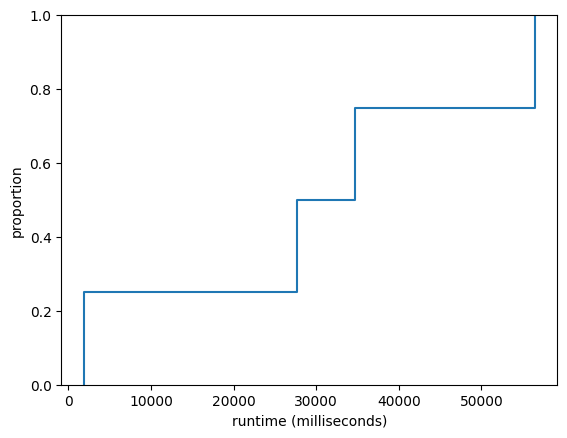

DistributionSummary(mean=30178.5, median=31191.5, modes=array([1881]), std=19481.708607049844, mad=14402.5, min_=1881, p25=21204.0, p75=40166.0, max_=56450)

In [28]:
runtimes_np = np.array(runtimes)
plot_cdf(runtimes_np, 'runtime (milliseconds)', 'online_runtime')
plt.show()
summarize_distribution(runtimes_np)

### Model

Proportion of energy cost to delay cost

In [ ]:
ec_vs_rl = energy_cost / revenue_loss if revenue_loss > 0 else np.Inf
hc_vs_sc = (energy_cost + revenue_loss) / switching_cost
ec_vs_rl, hc_vs_sc

(4.928890525519765, 1841.2474518509073)